# Hidden slides 

In [7]:
from keras.applications.vgg16 import (VGG16, preprocess_input, decode_predictions)
from tensorflow.keras.preprocessing import image
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

def normalize(x):
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def image_preprocessing(val, index):
    img = val.copy()
    x = img[index]
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = ma.masked_where(x>9999, x)
    return x

In [9]:
import cartopy.crs as ccrs
import matplotlib.ticker as mticker

def show(heatmap):
    proj = ccrs.PlateCarree(central_longitude=180)
    img_extent= (-180, 180, -55, 65)
    
    fig = plt.figure()
    ax = plt.subplot(projection=proj)
    ax.coastlines(resolution='50m', lw=0.5)
    ax.gridlines(xlocs = mticker.MultipleLocator(90),
                 ylocs = mticker.MultipleLocator(45),
                 linestyle = '-',
                 color = 'gray')
    mat = ax.matshow(heatmap,
                     cmap = 'BuPu',
                     extent = img_extent,
                     transform=proj)
    cbar = fig.colorbar(mat,
                        ax=ax,
                        orientation='horizontal')

In [10]:
def two_show(img, heatmap):
    proj = ccrs.PlateCarree(central_longitude=180)
    img_extent= (-180, 180, -55, 65)
    fig = plt.figure()
    ax = fig.add_subplot(211, projection=proj)
    ax.coastlines(resolution='50m', lw=0.5)
    ax.gridlines(xlocs = mticker.MultipleLocator(90),
                 ylocs = mticker.MultipleLocator(45),
                 linestyle = '-',
                 color = 'gray')
    mat = ax.matshow(heatmap,
                     cmap = 'BuPu',
                     extent = img_extent,
                     transform=proj)
    cbar = fig.colorbar(mat,
                        ax=ax,
                        orientation='horizontal')
    
    
    ax = fig.add_subplot(212, projection=proj)
    mat = ax.matshow(img,
                     cmap = 'RdBu_r',
                     norm = colors.Normalize(vmin=-3, vmax=3),
                    )
    cbar = fig.colorbar(mat,
                        ax=ax,
                        orientation='horizontal')

# 深層の探検ツアー
東工大 D3 梶山 青春 @ 鼎研究室
<div align="center">
    <img width='1500' src="src/madeinabyss.jpg">
<div>

# データの読み込み

In [1]:
import numpy as np
import numpy.ma as ma

npz = np.load('data/inputdata.npz')
x_train, y_train, x_val, y_val = npz["x_train"], npz["y_train"], npz["x_val"], npz["y_val"]
print(f'x_train: {x_train.shape}',
      f'y_train: {y_train.shape}',
      f'x_val: {x_val.shape}',
      f'y_val: {y_val.shape}'
     )
x_train_masked = ma.masked_where(x_train>9999, x_train)
x_val_masked = ma.masked_where(x_val>9999, x_val)

x_train: (1000, 24, 72, 3) y_train: (1000,) x_val: (100, 24, 72, 3) y_val: (100,)


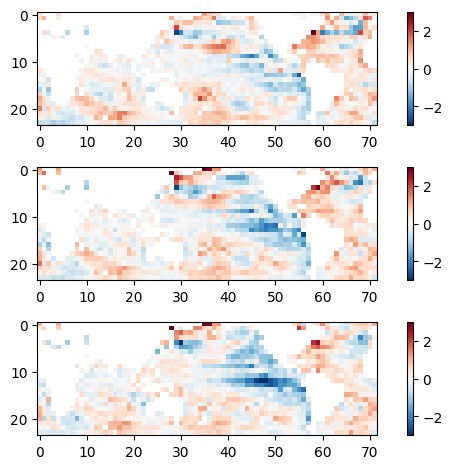

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

fig, axes = plt.subplots(3, 1, tight_layout=True)
for i in range(3):
    img = axes[i].imshow(x_train_masked[0,:,:,i], cmap='RdBu_r', norm = colors.Normalize(vmin=-3, vmax=3))
    plt.colorbar(img, ax=axes[i])

# Convolutional Neural Network 

|  項目 |  値  |
| ---- | ---- |
|  入力データ  | 海面水温偏差3か月 |
| 出力データ   | タイ北部月平均降水量 |
|  予測月   |  8月平均雨量  |
|  予測リードタイム | 1か月予測 |
|  解像度　|  5°x 5°(24x72グリッド) |
|  訓練データ数  |  1000  |
|  検証データ数　|  100   |

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses

def build_model():
    model = models.Sequential()
    model.add(layers.Conv2D(30, (4,8), activation='tanh', input_shape=(24, 72, 3), padding='SAME'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(30, (2,4), activation='tanh', padding='SAME'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(30, (2,4), activation='tanh', padding='SAME'))
    model.add(layers.Flatten())
    model.add(layers.Dense(30, activation='tanh'))
    model.add(layers.Dense(1, activation='linear'))

    optimizer = tf.keras.optimizers.RMSprop(0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

2022-11-24 15:42:31.239947: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-24 15:42:31.447964: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-24 15:42:31.453435: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-24 15:42:31.453464: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

<div align="center">
    <img width='1000' src="src/cnn.png">
<div>

In [4]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 72, 30)        2910      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 36, 30)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 36, 30)        7230      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 18, 30)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 18, 30)         7230      
                                                                 
 flatten (Flatten)           (None, 3240)              0

2022-11-24 15:42:33.675469: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-24 15:42:33.675535: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-24 15:42:33.675589: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (6a357af352d6): /proc/driver/nvidia/version does not exist
2022-11-24 15:42:33.675992: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 訓練と予測結果

In [5]:
history = model.fit(x_train_masked, y_train,
                    epochs=10, batch_size=200, verbose=2)
#model.save_weights('ckpt/weights.h5')

Epoch 1/10
5/5 - 1s - loss: 1.4061 - mae: 0.9178 - 1s/epoch - 266ms/step
Epoch 2/10
5/5 - 1s - loss: 0.7753 - mae: 0.6797 - 646ms/epoch - 129ms/step
Epoch 3/10
5/5 - 1s - loss: 0.7126 - mae: 0.6278 - 591ms/epoch - 118ms/step
Epoch 4/10
5/5 - 1s - loss: 0.6575 - mae: 0.6144 - 537ms/epoch - 107ms/step
Epoch 5/10
5/5 - 1s - loss: 0.6825 - mae: 0.6067 - 547ms/epoch - 109ms/step
Epoch 6/10
5/5 - 1s - loss: 0.5185 - mae: 0.5348 - 519ms/epoch - 104ms/step
Epoch 7/10
5/5 - 1s - loss: 0.5721 - mae: 0.5576 - 511ms/epoch - 102ms/step
Epoch 8/10
5/5 - 0s - loss: 0.4957 - mae: 0.5277 - 497ms/epoch - 99ms/step
Epoch 9/10
5/5 - 1s - loss: 0.5100 - mae: 0.5293 - 521ms/epoch - 104ms/step
Epoch 10/10
5/5 - 1s - loss: 0.4485 - mae: 0.4927 - 518ms/epoch - 104ms/step


4/4 [==============================] - 0s 11ms/step


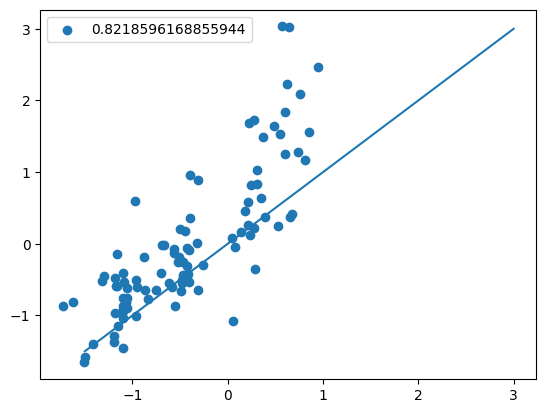

In [6]:
pred_val = model.predict(x_val_masked)
plt.scatter(pred_val, y_val, label=f'{np.corrcoef(pred_val[:,0], y_val)[0,1]}')
plt.plot(np.linspace(-1.5,3),np.linspace(-1.5,3))
plt.legend()

# ブラックボックス問題
<div align="center">
    <img width='1000' src="src/chainsawman.png">
<div>

<div align="center">
    <img width='1000' src="src/suzumenotogimari.png">
<div>

# Grad-CAMのすすめ
<div align="center">
    <img width='1000' src="src/cam.png">
<div>
    
### 1. CAM

k枚目の特徴量マップの位置x,yについての特徴量マップ: $A^k_{x,y}$

特徴量マップの要素数: Z

出力層の値: $S_c$

$S_c=\sum_kw^k_c*\frac{1}{Z}\sum_{x,y}A^k_{xy}$

$S_c=\frac{1}{Z}\sum_{x,y}M^c_{CAM}(x,y)$

すべてのx,yについてMを見た時に大きければ，x,yが予測に良い影響を与えたという発想

💡 モデルの形に制約が存在するためGrad-CAMで一般化された



### 2. Grad-CAM

$w^k_c$の代わりに$\alpha^k_c=\frac{1}{Z}\sum_{x,y}\frac{{\partial}S_c}{{\partial}A^k_{xy}}$を使えるよ！

$M^c_{Grad_CAM}(x,y)=\sum_k{\alpha^k_c}{A^k_{xy}}$

💡 計算のために必要なのは出力に対する特徴量マップの勾配である



In [8]:
import keras.backend as K
import cv2

def grad_cam(input_model, image, y_val, layer_name):
    # ----1. 予測のLossを計算---
    pred_val = input_model.output[0]
    y_val = tf.convert_to_tensor(y_val.astype(np.float32))
    loss = K.mean(K.square(pred_val - y_val))
    conv_output = input_model.get_layer(layer_name).output
    # ---2. 予測のLossから最後のconv層への勾配を計算---
    grads = normalize(K.gradients(loss, conv_output)[0])
    output, grads_val = K.function([input_model.layers[0].input], [conv_output, grads])([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    # ---3. 最後のconv層チャンネルごとに勾配の平均を計算して，各チャンネルの重要度とする
    weights = np.mean(grads_val, axis = (0,1))
    # ---4. 最後のconv層の順伝搬の出力にチャンネルごとの重みをかけて，足し合わせる---
    cam = np.dot(output, weights)
    cam = cv2.resize(cam, (72, 24), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    heatmap = (cam - np.min(cam)) / (np.max(cam) - np. min(cam))
    return heatmap

# Grad-CAMの例

In [11]:
model_grads = build_model()

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2022-11-24 15:42:41.295096: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2022-11-24 15:42:41.310319: W tensorflow/c/c_api.cc:291] Operation '{name:'total/Assign' id:140 op device:{requested: '', assigned: ''} def:{{{node total/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total, total/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2022-11-24 15:42:41.416672: W tensorflow/c/c_api.cc:291] Operation '{name:'conv2d_5/Tanh' id:76 

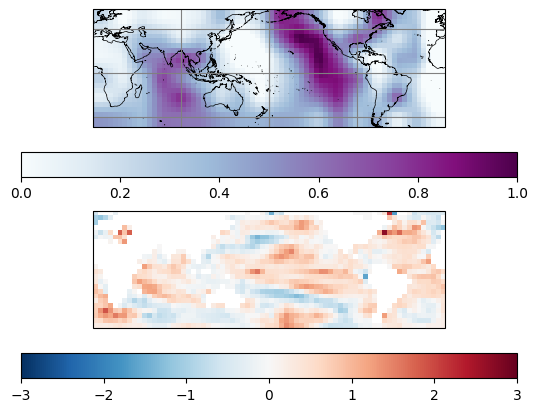

In [12]:
index = 0 #0, 23, 28
preprocessed_input = image_preprocessing(x_val_masked, index=index)
predictions = model_grads.predict(preprocessed_input)
heatmap = grad_cam(model_grads, preprocessed_input, y_val, "conv2d_5")
two_show(x_val_masked[index,:,:,0], heatmap)

2022-11-24 15:42:43.676975: W tensorflow/c/c_api.cc:291] Operation '{name:'conv2d_5/Tanh' id:76 op device:{requested: '', assigned: ''} def:{{{node conv2d_5/Tanh}} = Tanh[T=DT_FLOAT, _has_manual_control_dependencies=true](conv2d_5/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2022-11-24 15:42:43.764363: W tensorflow/c/c_api.cc:291] Operation '{name:'conv2d_5/Tanh' id:76 op device:{requested: '', assigned: ''} def:{{{node conv2d_5/Tanh}} = Tanh[T=DT_FLOAT, _has_manual_control_dependencies=true](conv2d_5/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2022-11-24 15:42:43.841013: W tensorflow/c/c_api.cc:291] Operation '{name:'conv2d_5/Tanh' id:7

2022-11-24 15:42:45.603111: W tensorflow/c/c_api.cc:291] Operation '{name:'conv2d_5/Tanh' id:76 op device:{requested: '', assigned: ''} def:{{{node conv2d_5/Tanh}} = Tanh[T=DT_FLOAT, _has_manual_control_dependencies=true](conv2d_5/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2022-11-24 15:42:45.717387: W tensorflow/c/c_api.cc:291] Operation '{name:'conv2d_5/Tanh' id:76 op device:{requested: '', assigned: ''} def:{{{node conv2d_5/Tanh}} = Tanh[T=DT_FLOAT, _has_manual_control_dependencies=true](conv2d_5/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2022-11-24 15:42:45.815453: W tensorflow/c/c_api.cc:291] Operation '{name:'conv2d_5/Tanh' id:7

2022-11-24 15:42:48.065752: W tensorflow/c/c_api.cc:291] Operation '{name:'conv2d_5/Tanh' id:76 op device:{requested: '', assigned: ''} def:{{{node conv2d_5/Tanh}} = Tanh[T=DT_FLOAT, _has_manual_control_dependencies=true](conv2d_5/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2022-11-24 15:42:48.200150: W tensorflow/c/c_api.cc:291] Operation '{name:'conv2d_5/Tanh' id:76 op device:{requested: '', assigned: ''} def:{{{node conv2d_5/Tanh}} = Tanh[T=DT_FLOAT, _has_manual_control_dependencies=true](conv2d_5/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2022-11-24 15:42:48.345416: W tensorflow/c/c_api.cc:291] Operation '{name:'conv2d_5/Tanh' id:7

2022-11-24 15:42:51.035465: W tensorflow/c/c_api.cc:291] Operation '{name:'conv2d_5/Tanh' id:76 op device:{requested: '', assigned: ''} def:{{{node conv2d_5/Tanh}} = Tanh[T=DT_FLOAT, _has_manual_control_dependencies=true](conv2d_5/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2022-11-24 15:42:51.198342: W tensorflow/c/c_api.cc:291] Operation '{name:'conv2d_5/Tanh' id:76 op device:{requested: '', assigned: ''} def:{{{node conv2d_5/Tanh}} = Tanh[T=DT_FLOAT, _has_manual_control_dependencies=true](conv2d_5/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2022-11-24 15:42:51.376654: W tensorflow/c/c_api.cc:291] Operation '{name:'conv2d_5/Tanh' id:7

2022-11-24 15:42:54.583960: W tensorflow/c/c_api.cc:291] Operation '{name:'conv2d_5/Tanh' id:76 op device:{requested: '', assigned: ''} def:{{{node conv2d_5/Tanh}} = Tanh[T=DT_FLOAT, _has_manual_control_dependencies=true](conv2d_5/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2022-11-24 15:42:54.767870: W tensorflow/c/c_api.cc:291] Operation '{name:'conv2d_5/Tanh' id:76 op device:{requested: '', assigned: ''} def:{{{node conv2d_5/Tanh}} = Tanh[T=DT_FLOAT, _has_manual_control_dependencies=true](conv2d_5/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2022-11-24 15:42:54.958060: W tensorflow/c/c_api.cc:291] Operation '{name:'conv2d_5/Tanh' id:7

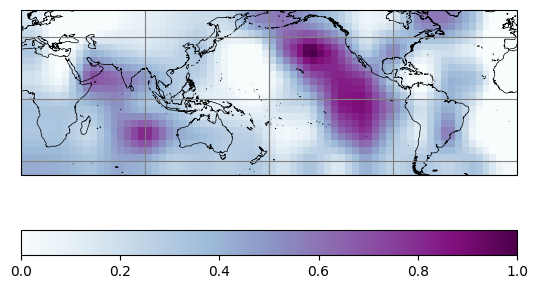

In [13]:
saliency = np.empty(x_val_masked.shape[:3])
for i in range(len(x_val_masked)):
    preprocessed_input = image_preprocessing(x_val_masked, index=i)
    predictions = model_grads.predict(preprocessed_input)
    heatmap = grad_cam(model_grads, preprocessed_input, y_val, "conv2d_5")
    saliency[i,:,:] = heatmap
saliency = saliency.mean(axis=0)
show(heatmap)